"""
=============================================================================
ADVANCED EXPLORATORY DATA ANALYSIS & FEATURE ENGINEERING
Risk-Based Authentication System for Zero Trust GitLab Security
=============================================================================

PURPOSE:
This script performs deep analysis and feature engineering on login data to:
1. Identify attack patterns and anomalous behavior
2. Create ML-ready features for risk scoring
3. Understand user behavior baselines
4. Detect account takeover indicators
5. Build features for LightGBM risk prediction model

GOAL:
Transform raw login data into meaningful risk indicators that can predict:
- Low Risk (0.00-0.29): Allow login
- Medium Risk (0.30-0.69): Require step-up MFA
- High Risk (0.70-1.00): Block login + alert security team

DATASET: RBA Dataset - 312,706 login events (10% sample of 33M records)
"""

# Data Cleaning

In [98]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.dpi'] = 100      # Display DPI (for notebooks)
plt.rcParams['savefig.dpi'] = 350     # Save DPI (high quality!)

print("=" * 70)
print("RISK-BASED AUTHENTICATION SYSTEM - EDA")
print("=" * 70)

RISK-BASED AUTHENTICATION SYSTEM - EDA


In [99]:
# %%
# ============================================================================
# STEP 1: LOAD DATASET
# ============================================================================

try:
    # Method 1: Load 10% of rows using skiprows (faster, less memory)
    # This randomly skips 90% of rows while loading
    
    # First, get total line count (optional, for progress tracking)
    print("📊 Loading 10% sample of the dataset...")
    
    # Load with random sampling - skiprows with lambda function
    # This keeps approximately 10% of rows
    df = pd.read_csv(
        '/kaggle/input/rba-dataset/rba-dataset.csv',
        skiprows=lambda i: i > 0 and np.random.random() > 0.1,  # Keep 10% of rows
        low_memory=False
    )
    
    print(f"✓ Dataset sample loaded successfully!")
    print(f"  Sample Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
    print(f"  Estimated Full Dataset: ~{df.shape[0] * 10:,} rows")
    print(f"  Memory Usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    
except FileNotFoundError:
    print("⚠ Dataset file not found!")
    print("\nTo download the dataset:")
    print("1. Visit: https://www.kaggle.com/datasets/dasgroup/rba-dataset")
    print("2. Download the CSV file")
    print("3. Place it in the same directory as this script")
    print("4. Update the filename in the code if needed")
    exit()
except MemoryError:
    print("⚠ Memory error! Trying with smaller sample (5%)...")
    try:
        df = pd.read_csv(
            '/kaggle/input/rba-dataset/rba-dataset.csv',
            skiprows=lambda i: i > 0 and np.random.random() > 0.05,  # Keep 5% of rows
            low_memory=False
        )
        print(f"✓ 5% sample loaded successfully!")
        print(f"  Sample Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
    except:
        print("❌ Unable to load dataset. Try further reducing sample size.")
        exit()

# Create a copy for cleaning
df_clean = df.copy()
print(f"\n✓ Working copy created for data cleaning")


📊 Loading 10% sample of the dataset...
✓ Dataset sample loaded successfully!
  Sample Shape: 3,127,552 rows × 16 columns
  Estimated Full Dataset: ~31,275,520 rows
  Memory Usage: 2307.84 MB

✓ Working copy created for data cleaning


In [100]:
# %%
# ============================================================================
# STEP 2: INITIAL DATA INSPECTION
# ============================================================================
print("\n[STEP 2] Initial Data Inspection")
print("-" * 70)

print("\n📊 Dataset Info:")
print(df.info())

print("\n📋 First 5 Rows:")
print(df.head())

print("\n📋 Column Names:")
print(df.columns.tolist())

print("\n📊 Data Types:")
print(df.dtypes.value_counts())



[STEP 2] Initial Data Inspection
----------------------------------------------------------------------

📊 Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3127552 entries, 0 to 3127551
Data columns (total 16 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   index                     int64  
 1   Login Timestamp           object 
 2   User ID                   int64  
 3   Round-Trip Time [ms]      float64
 4   IP Address                object 
 5   Country                   object 
 6   Region                    object 
 7   City                      object 
 8   ASN                       int64  
 9   User Agent String         object 
 10  Browser Name and Version  object 
 11  OS Name and Version       object 
 12  Device Type               object 
 13  Login Successful          bool   
 14  Is Attack IP              bool   
 15  Is Account Takeover       bool   
dtypes: bool(3), float64(1), int64(3), object(9)
memory usage: 

In [101]:
# %%
# ============================================================================
# STEP 3: BASIC STATISTICS
# ============================================================================
print("\n[STEP 3] Basic Statistics")
print("-" * 70)

print("\n📈 Numerical Features Summary:")
print(df.describe())

print("\n📈 Categorical Features Summary:")
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols[:5]:  # Show first 5 categorical columns
    print(f"\n{col}:")
    print(df[col].value_counts().head())



[STEP 3] Basic Statistics
----------------------------------------------------------------------

📈 Numerical Features Summary:
              index       User ID  Round-Trip Time [ms]           ASN
count  3.127552e+06  3.127552e+06         127138.000000  3.127552e+06
mean   1.562925e+07 -1.923760e+18            667.263021  1.621104e+05
std    9.028669e+06  4.514420e+18           1130.006325  1.718950e+05
min    1.000000e+01 -9.223369e+18              9.000000  1.200000e+01
25%    7.807611e+06 -4.324476e+18            472.000000  2.969500e+04
50%    1.562888e+07 -4.324476e+18            539.000000  4.116400e+04
75%    2.344683e+07  9.116553e+17            677.000000  3.933980e+05
max    3.126926e+07  9.223354e+18         115186.000000  5.077250e+05

📈 Categorical Features Summary:

Login Timestamp:
Login Timestamp
2020-02-03 12:44:19.260    1
2020-11-16 01:06:05.320    1
2020-11-16 01:00:30.429    1
2020-11-16 01:00:54.974    1
2020-11-16 01:01:19.099    1
Name: count, dtype: int64

IP


[STEP 4] Missing Values Analysis
----------------------------------------------------------------------

🔍 Missing Values:
                      Missing_Count  Percentage
Round-Trip Time [ms]        3000414   95.934904
Region                         4778    0.152771
City                            898    0.028713
Device Type                     165    0.005276


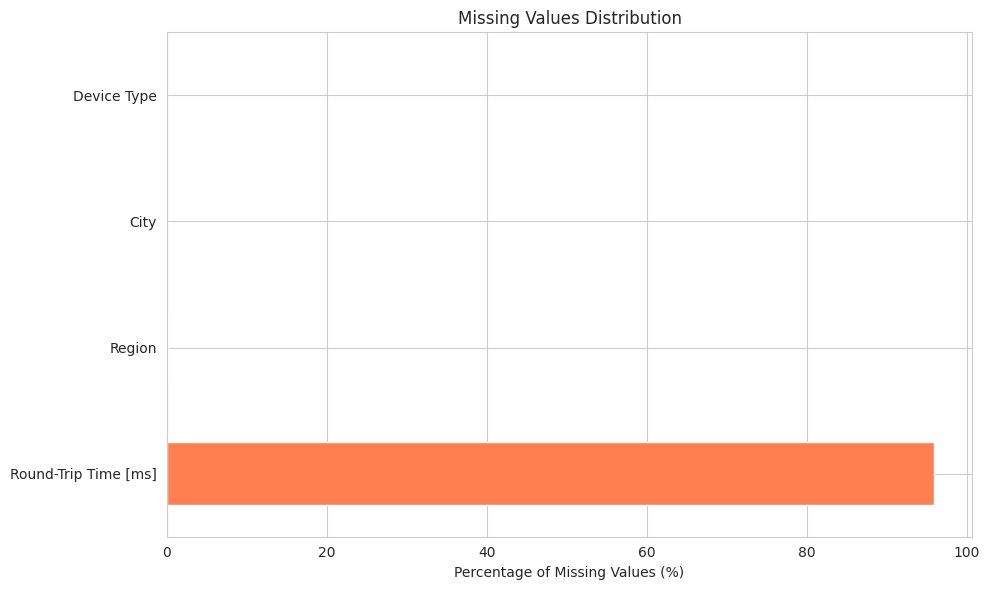

In [102]:
# %%
# ============================================================================
# STEP 4: MISSING VALUES ANALYSIS
# ============================================================================
print("\n[STEP 4] Missing Values Analysis")
print("-" * 70)

missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing_Count': missing,
    'Percentage': missing_pct
}).sort_values('Missing_Count', ascending=False)

print("\n🔍 Missing Values:")
print(missing_df[missing_df['Missing_Count'] > 0])

if missing_df['Missing_Count'].sum() == 0:
    print("✓ No missing values found!")

# Visualize missing values
missing_cols = missing_df[missing_df['Missing_Count'] > 0]
if len(missing_cols) > 0:
    plt.figure(figsize=(10, 6))
    missing_cols['Percentage'].sort_values(ascending=False).plot(kind='barh', color='coral')
    plt.xlabel('Percentage of Missing Values (%)')
    plt.title('Missing Values Distribution')
    plt.tight_layout()
    plt.show()


In [103]:
# %%
# ============================================================================
# STEP 5: HANDLE MISSING VALUES
# ============================================================================
print("\n[STEP 5] Handle Missing Values")
print("-" * 70)

# Identify columns with missing values
cols_with_missing = missing_df[missing_df['Missing_Count'] > 0].index.tolist()

if len(cols_with_missing) > 0:
    print(f"\n📋 Columns with missing values: {cols_with_missing}")
    
    cols_to_drop = []
    
    for col in cols_with_missing:
        missing_pct = (df_clean[col].isnull().sum() / len(df_clean)) * 100
        
        if missing_pct > 80:
            print(f"\n  ❌ {col}: {missing_pct:.2f}% missing (CRITICAL)")
            print(f"     Action: DROPPING column (too sparse for reliable analysis)")
            cols_to_drop.append(col)
        
        elif missing_pct > 50:
            print(f"\n  ⚠ {col}: {missing_pct:.2f}% missing (HIGH)")
            print(f"     Action: DROPPING column (insufficient data for imputation)")
            cols_to_drop.append(col)
        
        elif df_clean[col].dtype in ['float64', 'int64']:
            # For numerical columns: fill with median
            median_val = df_clean[col].median()
            df_clean[col].fillna(median_val, inplace=True)
            print(f"\n  ✓ {col}: {missing_pct:.2f}% missing")
            print(f"     Action: Filled with median ({median_val:.2f})")
        
        else:
            # For categorical columns: fill with mode
            mode_val = df_clean[col].mode()[0] if len(df_clean[col].mode()) > 0 else "Unknown"
            df_clean[col].fillna(mode_val, inplace=True)
            print(f"\n  ✓ {col}: {missing_pct:.2f}% missing")
            print(f"     Action: Filled with mode ({mode_val})")
    
    # Drop columns with critical missing values
    if cols_to_drop:
        print(f"\n{'─' * 70}")
        print(f"🗑 Dropping {len(cols_to_drop)} column(s) with insufficient data:")
        for col in cols_to_drop:
            print(f"   - {col}")
        df_clean.drop(cols_to_drop, axis=1, inplace=True)
        print(f"✓ Columns dropped successfully")
    
    print(f"\n{'─' * 70}")
    print(f"✓ Missing value handling complete!")
    print(f"  Remaining columns: {df_clean.shape[1]}")
    print(f"  Total missing values: {df_clean.isnull().sum().sum()}")
else:
    print("✓ No missing values to handle!")


[STEP 5] Handle Missing Values
----------------------------------------------------------------------

📋 Columns with missing values: ['Round-Trip Time [ms]', 'Region', 'City', 'Device Type']

  ❌ Round-Trip Time [ms]: 95.93% missing (CRITICAL)
     Action: DROPPING column (too sparse for reliable analysis)

  ✓ Region: 0.15% missing
     Action: Filled with mode (-)

  ✓ City: 0.03% missing
     Action: Filled with mode (-)

  ✓ Device Type: 0.01% missing
     Action: Filled with mode (mobile)

──────────────────────────────────────────────────────────────────────
🗑 Dropping 1 column(s) with insufficient data:
   - Round-Trip Time [ms]
✓ Columns dropped successfully

──────────────────────────────────────────────────────────────────────
✓ Missing value handling complete!
  Remaining columns: 15
  Total missing values: 0


In [104]:
# %%
# ============================================================================
# STEP 6: DUPLICATE DETECTION AND HANDLING
# ============================================================================
print("\n[STEP 6] Duplicate Detection and Handling")
print("-" * 70)

# Check for complete duplicates
complete_duplicates = df_clean.duplicated().sum()
print(f"\n📊 Complete Duplicates (all columns): {complete_duplicates}")

if complete_duplicates > 0:
    duplicate_pct = (complete_duplicates / len(df_clean)) * 100
    print(f"   Percentage: {duplicate_pct:.2f}%")
    
    # Remove complete duplicates
    df_clean = df_clean.drop_duplicates()
    print(f"   ✓ Removed {complete_duplicates} complete duplicate rows")
    print(f"   New shape: {df_clean.shape}")



[STEP 6] Duplicate Detection and Handling
----------------------------------------------------------------------

📊 Complete Duplicates (all columns): 0


In [105]:
# %%
# ============================================================================
# STEP 7: OUTLIER DETECTION (EXCLUDING USER ID)
# ============================================================================
print("\n[STEP 7] Outlier Detection (IQR Method)")
print("-" * 80)

numerical_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()

# Remove 'User ID' from outlier analysis
numerical_cols_for_outliers = [col for col in numerical_cols if col != 'User ID']

print(f"\n📋 Numerical columns for outlier analysis: {numerical_cols_for_outliers}")
print("   (User ID excluded as it's useful for feature engineering)")

outlier_summary = {}

for col in numerical_cols_for_outliers:
    Q1 = df_clean[col].quantile(0.25)
    Q3 = df_clean[col].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = ((df_clean[col] < lower_bound) | (df_clean[col] > upper_bound)).sum()
    outlier_pct = (outliers / len(df_clean)) * 100
    
    if outliers > 0:
        outlier_summary[col] = {
            'count': outliers,
            'percentage': outlier_pct,
            'lower_bound': lower_bound,
            'upper_bound': upper_bound
        }

if outlier_summary:
    print("\n🔍 Outliers Detected (IQR method):\n")
    for col, info in outlier_summary.items():
        print(f"  {col}:")
        print(f"    Count: {info['count']} ({info['percentage']:.2f}%)")
        print(f"    Range: [{info['lower_bound']:.2f}, {info['upper_bound']:.2f}]")
else:
    print("\n✓ No significant outliers detected!")

# Visualize outliers
if len(numerical_cols_for_outliers) > 0:
    fig, axes = plt.subplots(1, min(3, len(numerical_cols_for_outliers)), 
                             figsize=(15, 5))
    if len(numerical_cols_for_outliers) == 1:
        axes = [axes]
    
    for idx, col in enumerate(numerical_cols_for_outliers[:3]):
        axes[idx].boxplot(df_clean[col].dropna())
        axes[idx].set_title(f'Boxplot: {col}', fontsize=12, fontweight='bold')
        axes[idx].set_ylabel('Value')
    
    plt.tight_layout()
    plt.savefig('07_outlier_detection.png', dpi=350, bbox_inches='tight')
    print("\n✓ Saved: 07_outlier_detection.png")
    plt.close()



[STEP 7] Outlier Detection (IQR Method)
--------------------------------------------------------------------------------

📋 Numerical columns for outlier analysis: ['index', 'ASN']
   (User ID excluded as it's useful for feature engineering)

✓ No significant outliers detected!

✓ Saved: 07_outlier_detection.png


In [106]:
# %%
# ============================================================================
# STEP 8: DATA TYPE VALIDATION AND CONVERSION
# ============================================================================
print("\n[STEP 8] Data Type Validation and Conversion")
print("-" * 80)

print("\n📊 Current Data Types:")
print(df_clean.dtypes)

# Define specific data type conversions
dtype_conversions = {
    'Login Timestamp': 'datetime64[ns]',
    'User ID': 'int64',
    'Round-Trip Time [ms]': 'float64',
    'IP Address': 'string',
    'Country': 'category',
    'Region': 'category',
    'City': 'category',
    'ASN': 'int64',
    'User Agent String': 'string',
    'Browser Name and Version': 'string',
    'OS Name and Version': 'string',
    'Device Type': 'category',
    'Login Successful': 'bool',
    'Is Attack IP': 'bool',
    'Is Account Takeover': 'bool'
}

print("\n🔄 Applying data type conversions:")
for col, dtype in dtype_conversions.items():
    if col in df_clean.columns:
        try:
            if dtype == 'datetime64[ns]':
                df_clean[col] = pd.to_datetime(df_clean[col])
            elif dtype == 'category':
                df_clean[col] = df_clean[col].astype(dtype)
            else:
                df_clean[col] = df_clean[col].astype(dtype)
            print(f"  ✓ {col}: Converted to {dtype}")
        except Exception as e:
            print(f"  ⚠ {col}: Could not convert to {dtype} - {str(e)}")

print("\n✓ Data type conversion complete!")
print(f"\nUpdated Data Types:")
print(df_clean.dtypes)



[STEP 8] Data Type Validation and Conversion
--------------------------------------------------------------------------------

📊 Current Data Types:
index                        int64
Login Timestamp             object
User ID                      int64
IP Address                  object
Country                     object
Region                      object
City                        object
ASN                          int64
User Agent String           object
Browser Name and Version    object
OS Name and Version         object
Device Type                 object
Login Successful              bool
Is Attack IP                  bool
Is Account Takeover           bool
dtype: object

🔄 Applying data type conversions:
  ✓ Login Timestamp: Converted to datetime64[ns]
  ✓ User ID: Converted to int64
  ✓ IP Address: Converted to string
  ✓ Country: Converted to category
  ✓ Region: Converted to category
  ✓ City: Converted to category
  ✓ ASN: Converted to int64
  ✓ User Agent String: Convert

In [107]:
# %%
# ============================================================================
# STEP 9: WHITESPACE AND FORMAT CLEANING
# ============================================================================
print("\n[STEP 9] Whitespace and Format Cleaning")
print("-" * 80)

categorical_cols = df_clean.select_dtypes(include=['category']).columns

for col in categorical_cols:
    df_clean[col] = df_clean[col].str.strip()
    print(f"  ✓ {col}: Cleaned whitespace")

string_cols = df_clean.select_dtypes(include=['string']).columns
for col in string_cols:
    df_clean[col] = df_clean[col].str.strip()
    print(f"  ✓ {col}: Cleaned whitespace")

print("\n✓ Format cleaning complete!")


[STEP 9] Whitespace and Format Cleaning
--------------------------------------------------------------------------------
  ✓ Country: Cleaned whitespace
  ✓ Region: Cleaned whitespace
  ✓ City: Cleaned whitespace
  ✓ Device Type: Cleaned whitespace
  ✓ IP Address: Cleaned whitespace
  ✓ User Agent String: Cleaned whitespace
  ✓ Browser Name and Version: Cleaned whitespace
  ✓ OS Name and Version: Cleaned whitespace

✓ Format cleaning complete!


In [108]:
# %%
# ============================================================================
# STEP 10: VALUE CONSISTENCY CHECK
# ============================================================================
print("\n[STEP 10] Value Consistency Check")
print("-" * 80)

categorical_cols = df_clean.select_dtypes(include=['category']).columns

print("\n📋 Unique values per categorical column:\n")
for col in categorical_cols:
    unique_count = df_clean[col].nunique()
    print(f"  {col}: {unique_count} unique values")
    if unique_count <= 15:
        print(f"    Values: {df_clean[col].unique()}")

print("\n✓ Value consistency check complete!")



[STEP 10] Value Consistency Check
--------------------------------------------------------------------------------

📋 Unique values per categorical column:


✓ Value consistency check complete!


In [109]:
# %%
# ============================================================================
# STEP 11: DESCRIPTIVE STATISTICS AFTER CLEANING
# ============================================================================
print("\n[STEP 11] Descriptive Statistics (After Cleaning)")
print("-" * 80)

print("\n📈 Numerical Features Summary:")
print(df_clean.describe())

print(f"\n📊 Dataset Shape After Cleaning: {df_clean.shape}")
print(f"   Rows removed: {df.shape[0] - df_clean.shape[0]}")

print("\n" + "=" * 80)
print("CLEANING SUMMARY")
print("=" * 80)
print(f"Original rows:      {df.shape[0]:,}")
print(f"Cleaned rows:       {df_clean.shape[0]:,}")
print(f"Original columns:   {df.shape[1]}")
print(f"Cleaned columns:    {df_clean.shape[1]}")
print(f"Duplicates removed: {complete_duplicates}")
print(f"Memory saved:       {(df.memory_usage(deep=True).sum() - df_clean.memory_usage(deep=True).sum()) / 1024**2:.2f} MB")
print("=" * 80)


[STEP 11] Descriptive Statistics (After Cleaning)
--------------------------------------------------------------------------------

📈 Numerical Features Summary:
              index                Login Timestamp       User ID           ASN
count  3.127552e+06                        3127552  3.127552e+06  3.127552e+06
mean   1.562925e+07  2020-08-29 02:18:42.019787008 -1.923760e+18  1.621104e+05
min    1.000000e+01     2020-02-03 12:44:19.260000 -9.223369e+18  1.200000e+01
25%    7.807611e+06  2020-05-20 12:45:53.145250048 -4.324476e+18  2.969500e+04
50%    1.562888e+07  2020-09-07 19:09:10.845000192 -4.324476e+18  4.116400e+04
75%    2.344683e+07  2020-12-07 09:04:40.372999936  9.116553e+17  3.933980e+05
max    3.126926e+07     2021-02-28 23:59:49.956000  9.223354e+18  5.077250e+05
std    9.028669e+06                            NaN  4.514420e+18  1.718950e+05

📊 Dataset Shape After Cleaning: (3127552, 15)
   Rows removed: 0

CLEANING SUMMARY
Original rows:      3,127,552
Cleaned rows


[STEP 12] Distribution Analysis
--------------------------------------------------------------------------------

✓ Saved: 12_distribution_analysis.png


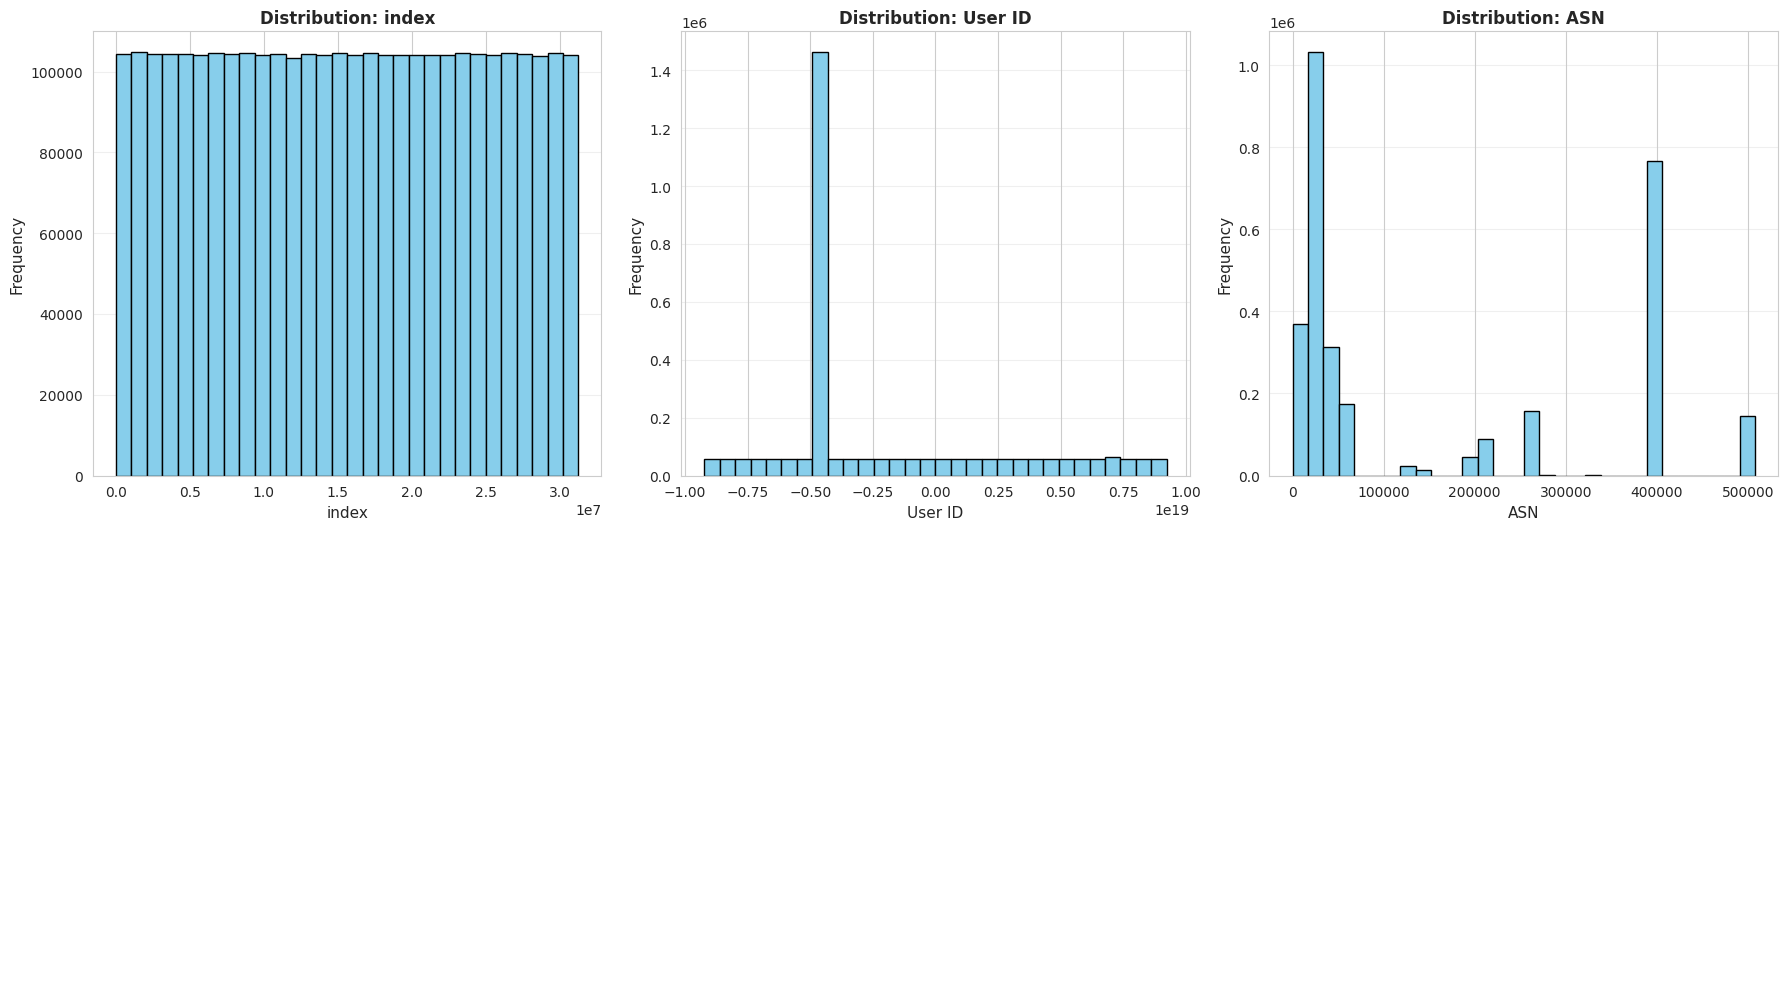


✓ Distribution analysis complete!


In [110]:
# %%
# ============================================================================
# STEP 12: DISTRIBUTION ANALYSIS
# ============================================================================
print("\n[STEP 12] Distribution Analysis")
print("-" * 80)

numerical_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()

if len(numerical_cols) > 0:
    num_cols_to_plot = min(6, len(numerical_cols))
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()
    
    for idx, col in enumerate(numerical_cols[:num_cols_to_plot]):
        axes[idx].hist(df_clean[col].dropna(), bins=30, color='skyblue', edgecolor='black')
        axes[idx].set_title(f'Distribution: {col}', fontsize=12, fontweight='bold')
        axes[idx].set_xlabel(col, fontsize=11)
        axes[idx].set_ylabel('Frequency', fontsize=11)
        axes[idx].grid(axis='y', alpha=0.3)
    
    for idx in range(num_cols_to_plot, 6):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.savefig('12_distribution_analysis.png', dpi=350, bbox_inches='tight')
    print("\n✓ Saved: 12_distribution_analysis.png")
    plt.show()
    plt.close()

print("\n✓ Distribution analysis complete!")



[STEP 13] Correlation Analysis
--------------------------------------------------------------------------------

📊 Correlation Matrix:
         index      ASN
index  1.00000  0.07282
ASN    0.07282  1.00000

✓ Saved: 13_correlation_analysis.png


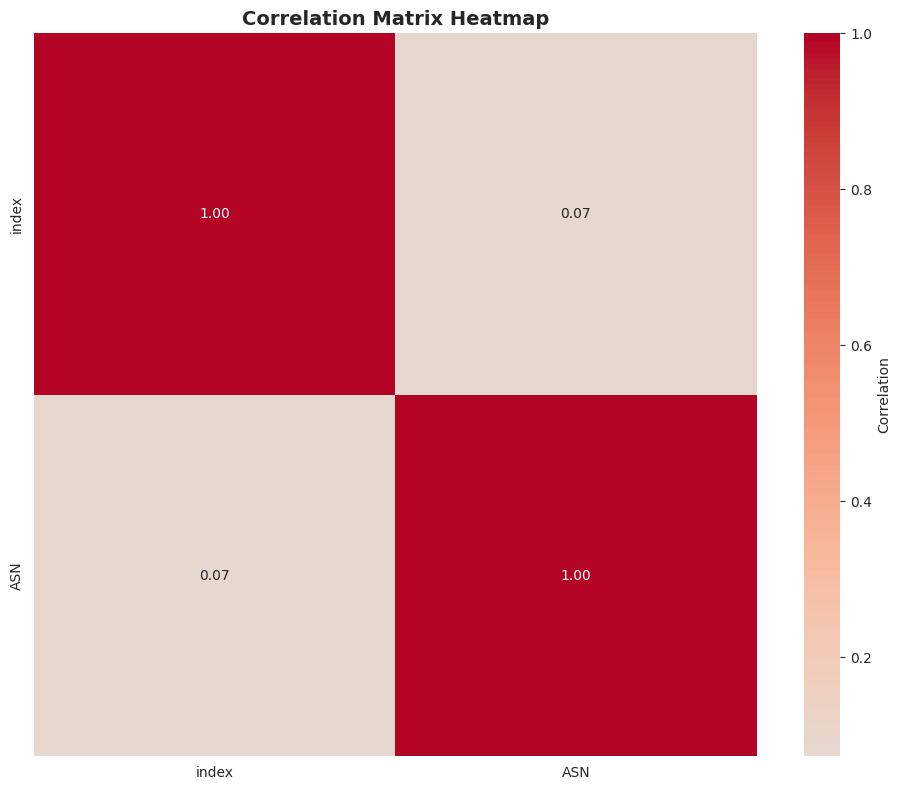


✓ No high correlations found (>0.7)

✓ Correlation analysis complete!


In [111]:
# %%
# ============================================================================
# STEP 13: CORRELATION ANALYSIS
# ============================================================================
print("\n[STEP 13] Correlation Analysis")
print("-" * 80)

numerical_cols_for_corr = [col for col in numerical_cols if col != 'User ID']

if len(numerical_cols_for_corr) > 1:
    correlation_matrix = df_clean[numerical_cols_for_corr].corr()
    
    print("\n📊 Correlation Matrix:")
    print(correlation_matrix)
    
    # Plot correlation heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
                fmt='.2f', square=True, cbar_kws={'label': 'Correlation'})
    plt.title('Correlation Matrix Heatmap', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('13_correlation_analysis.png', dpi=350, bbox_inches='tight')
    print("\n✓ Saved: 13_correlation_analysis.png")
    plt.show()
    plt.close()
    
    # Find high correlations
    high_corr = []
    for i in range(len(correlation_matrix.columns)):
        for j in range(i + 1, len(correlation_matrix.columns)):
            if abs(correlation_matrix.iloc[i, j]) > 0.7:
                high_corr.append({
                    'Feature 1': correlation_matrix.columns[i],
                    'Feature 2': correlation_matrix.columns[j],
                    'Correlation': correlation_matrix.iloc[i, j]
                })
    
    if high_corr:
        print("\n⚠ High Correlations (>0.7):")
        for item in high_corr:
            print(f"  {item['Feature 1']} <-> {item['Feature 2']}: {item['Correlation']:.3f}")
    else:
        print("\n✓ No high correlations found (>0.7)")

print("\n✓ Correlation analysis complete!")




[STEP 14] Target Variable Analysis
--------------------------------------------------------------------------------

🎯 Target Variable: 'Is Attack IP'

Distribution:
Is Attack IP
False    2817471
True      310081
Name: count, dtype: int64

Proportions:
Is Attack IP
False    0.900855
True     0.099145
Name: proportion, dtype: float64

✓ Saved: 14_target_is_attack_ip.png


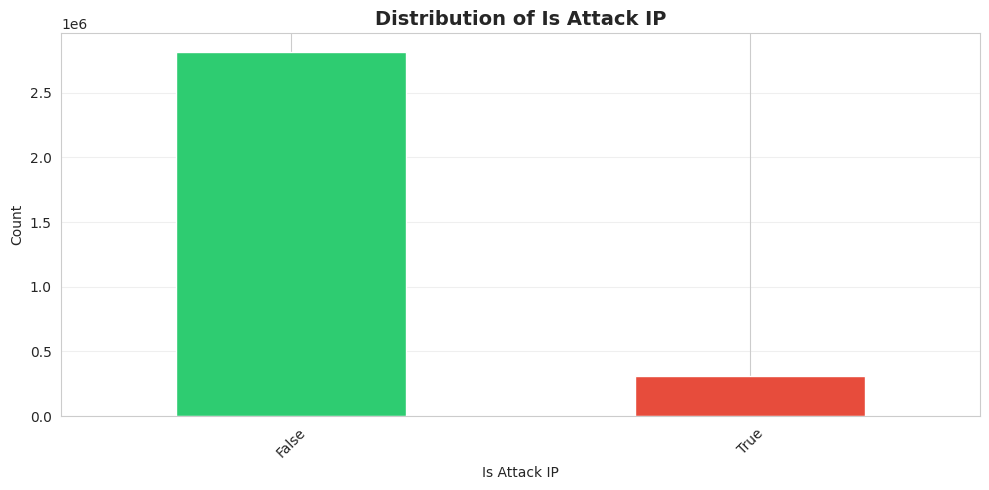


🎯 Target Variable: 'Is Account Takeover'

Distribution:
Is Account Takeover
False    3127533
True          19
Name: count, dtype: int64

Proportions:
Is Account Takeover
False    0.999994
True     0.000006
Name: proportion, dtype: float64

✓ Saved: 14_target_is_account_takeover.png


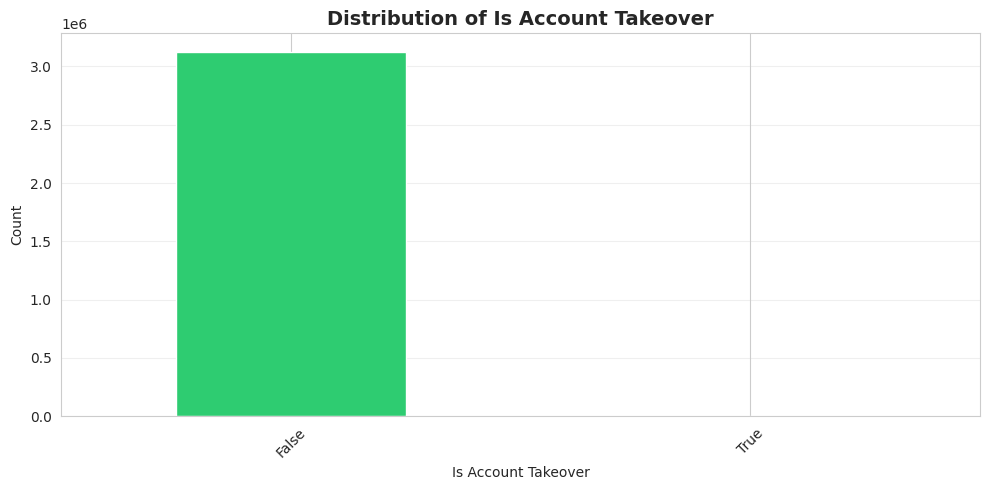


🎯 Target Variable: 'Login Successful'

Distribution:
Login Successful
False    1873637
True     1253915
Name: count, dtype: int64

Proportions:
Login Successful
False    0.599075
True     0.400925
Name: proportion, dtype: float64

✓ Saved: 14_target_login_successful.png


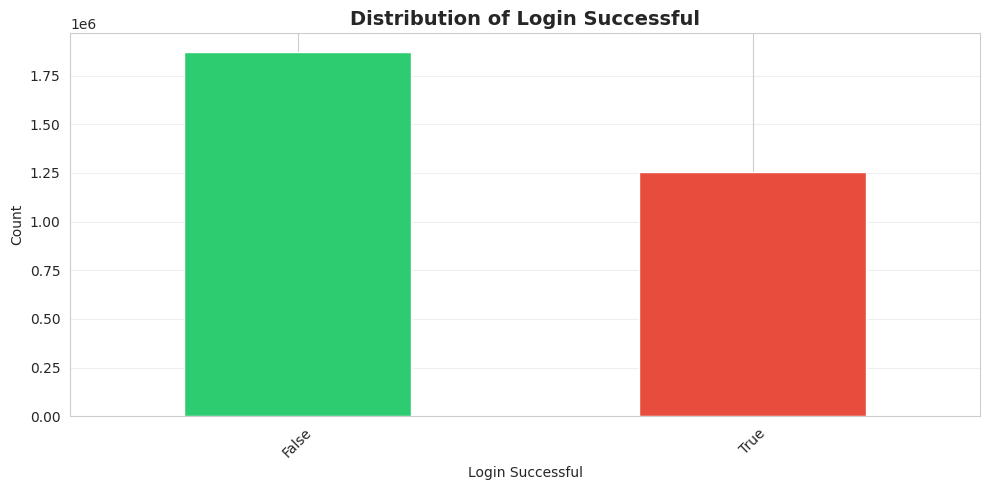

In [112]:
# ============================================================================
# STEP 14: TARGET VARIABLE ANALYSIS
# ============================================================================
print("\n[STEP 14] Target Variable Analysis")
print("-" * 80)

# Identify potential target columns
target_candidates = ['Is Attack IP', 'Is Account Takeover', 'Login Successful']

target_cols_found = [col for col in target_candidates if col in df_clean.columns]

if target_cols_found:
    for target_col in target_cols_found:
        print(f"\n🎯 Target Variable: '{target_col}'")
        print(f"\nDistribution:")
        print(df_clean[target_col].value_counts())
        print(f"\nProportions:")
        print(df_clean[target_col].value_counts(normalize=True))
        
        # Visualize target distribution
        plt.figure(figsize=(10, 5))
        colors = ['#2ecc71', '#e74c3c']
        df_clean[target_col].value_counts().plot(kind='bar', color=colors[:len(df_clean[target_col].value_counts())])
        plt.title(f'Distribution of {target_col}', fontsize=14, fontweight='bold')
        plt.xlabel(target_col)
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        plt.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        filename = f'14_target_{target_col.replace(" ", "_").lower()}.png'
        plt.savefig(filename, dpi=350, bbox_inches='tight')
        print(f"\n✓ Saved: {filename}")
        plt.show()
        plt.close()
else:
    print("⚠ Target columns not identified automatically")
    print(f"Available columns: {df_clean.columns.tolist()}")


[STEP 15] Attack Distribution Analysis
--------------------------------------------------------------------------------

🎯 Security Event Statistics:
       Login Success  Attack IP  Account Takeover
False        1873637    2817471           3127533
True         1253915     310081                19

📊 Percentages:
       Login Success  Attack IP  Account Takeover
False      59.907461  90.085505         99.999392
True       40.092539   9.914495          0.000608

⚠️  THREAT METRICS:
  • Attack IP Rate: 9.91%
  • Account Takeover Rate: 0.00%
  • Failed Login Rate: 59.91%
  • Class Imbalance Ratio: 1:10 (attacks:legitimate)


✓ Saved: 15_security_threat_landscape.png


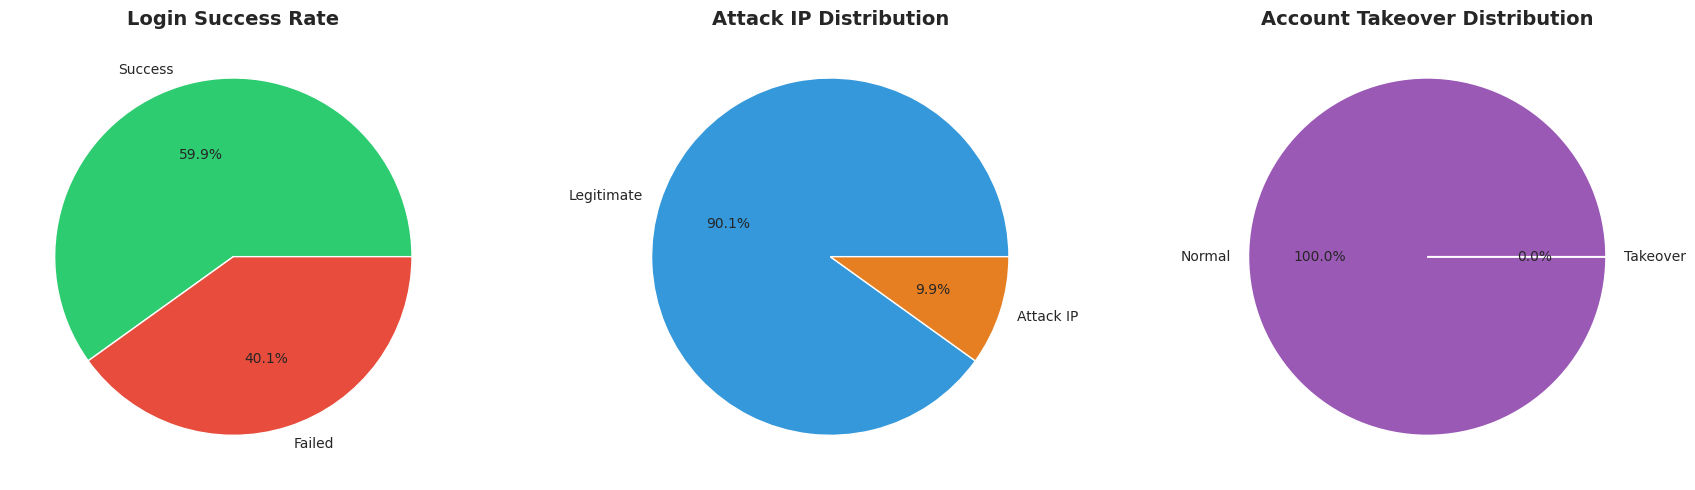

In [113]:
# %%
# ============================================================================
# STEP 15: ATTACK DISTRIBUTION ANALYSIS
# ============================================================================
print("\n[STEP 15] Attack Distribution Analysis")
print("-" * 80)

if 'Is Attack IP' in df_clean.columns and 'Is Account Takeover' in df_clean.columns and 'Login Successful' in df_clean.columns:
    attack_stats = pd.DataFrame({
        'Login Success': df_clean['Login Successful'].value_counts(),
        'Attack IP': df_clean['Is Attack IP'].value_counts(),
        'Account Takeover': df_clean['Is Account Takeover'].value_counts()
    })
    
    print("\n🎯 Security Event Statistics:")
    print(attack_stats)
    print("\n📊 Percentages:")
    print(attack_stats / len(df_clean) * 100)
    
    # Calculate class imbalance ratio
    attack_ratio = df_clean['Is Attack IP'].sum() / len(df_clean)
    takeover_ratio = df_clean['Is Account Takeover'].sum() / len(df_clean)
    failed_login_ratio = (~df_clean['Login Successful']).sum() / len(df_clean)
    
    print(f"""
⚠️  THREAT METRICS:
  • Attack IP Rate: {attack_ratio:.2%}
  • Account Takeover Rate: {takeover_ratio:.2%}
  • Failed Login Rate: {failed_login_ratio:.2%}
  • Class Imbalance Ratio: 1:{int(1/attack_ratio) if attack_ratio > 0 else 'inf'} (attacks:legitimate)
""")
    
    # Visualize security threats
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Plot 1: Login Success vs Failure
    df_clean['Login Successful'].value_counts().plot(kind='pie', ax=axes[0], autopct='%1.1f%%',
                                                colors=['#2ecc71', '#e74c3c'],
                                                labels=['Success', 'Failed'])
    axes[0].set_title('Login Success Rate', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('')
    
    # Plot 2: Attack IP Distribution
    df_clean['Is Attack IP'].value_counts().plot(kind='pie', ax=axes[1], autopct='%1.1f%%',
                                            colors=['#3498db', '#e67e22'],
                                            labels=['Legitimate', 'Attack IP'])
    axes[1].set_title('Attack IP Distribution', fontsize=14, fontweight='bold')
    axes[1].set_ylabel('')
    
    # Plot 3: Account Takeover
    df_clean['Is Account Takeover'].value_counts().plot(kind='pie', ax=axes[2], autopct='%1.1f%%',
                                                   colors=['#9b59b6', '#c0392b'],
                                                   labels=['Normal', 'Takeover'])
    axes[2].set_title('Account Takeover Distribution', fontsize=14, fontweight='bold')
    axes[2].set_ylabel('')
    
    plt.tight_layout()
    plt.savefig('15_security_threat_landscape.png', dpi=350, bbox_inches='tight')
    print("\n✓ Saved: 15_security_threat_landscape.png")
    plt.show()
    plt.close()


[STEP 16] Temporal Attack Pattern Analysis
--------------------------------------------------------------------------------

🕒 Attack Rate by Hour of Day:
        sum  attack_rate
hour                    
0      3762     8.566939
1      7158    13.291985
2     10984    16.701385
3     12523    17.041109
4     14401    16.993734
5     15413    14.777848
6     16369    12.384620
7     16694    10.803430
8     16140     9.682761
9     16363     9.414465
10    15846     9.228941
11    15476     9.113232
12    16163     9.418559
13    17710     9.922069
14    19986    10.742851
15    20833    11.148452
16    19402    10.448372
17    15731     9.059705
18    11864     7.382701
19    10376     6.627491
20     6410     5.029936
21     4175     4.510295
22     3284     5.072755
23     3018     6.230131

✓ Saved: 16_temporal_attack_patterns.png


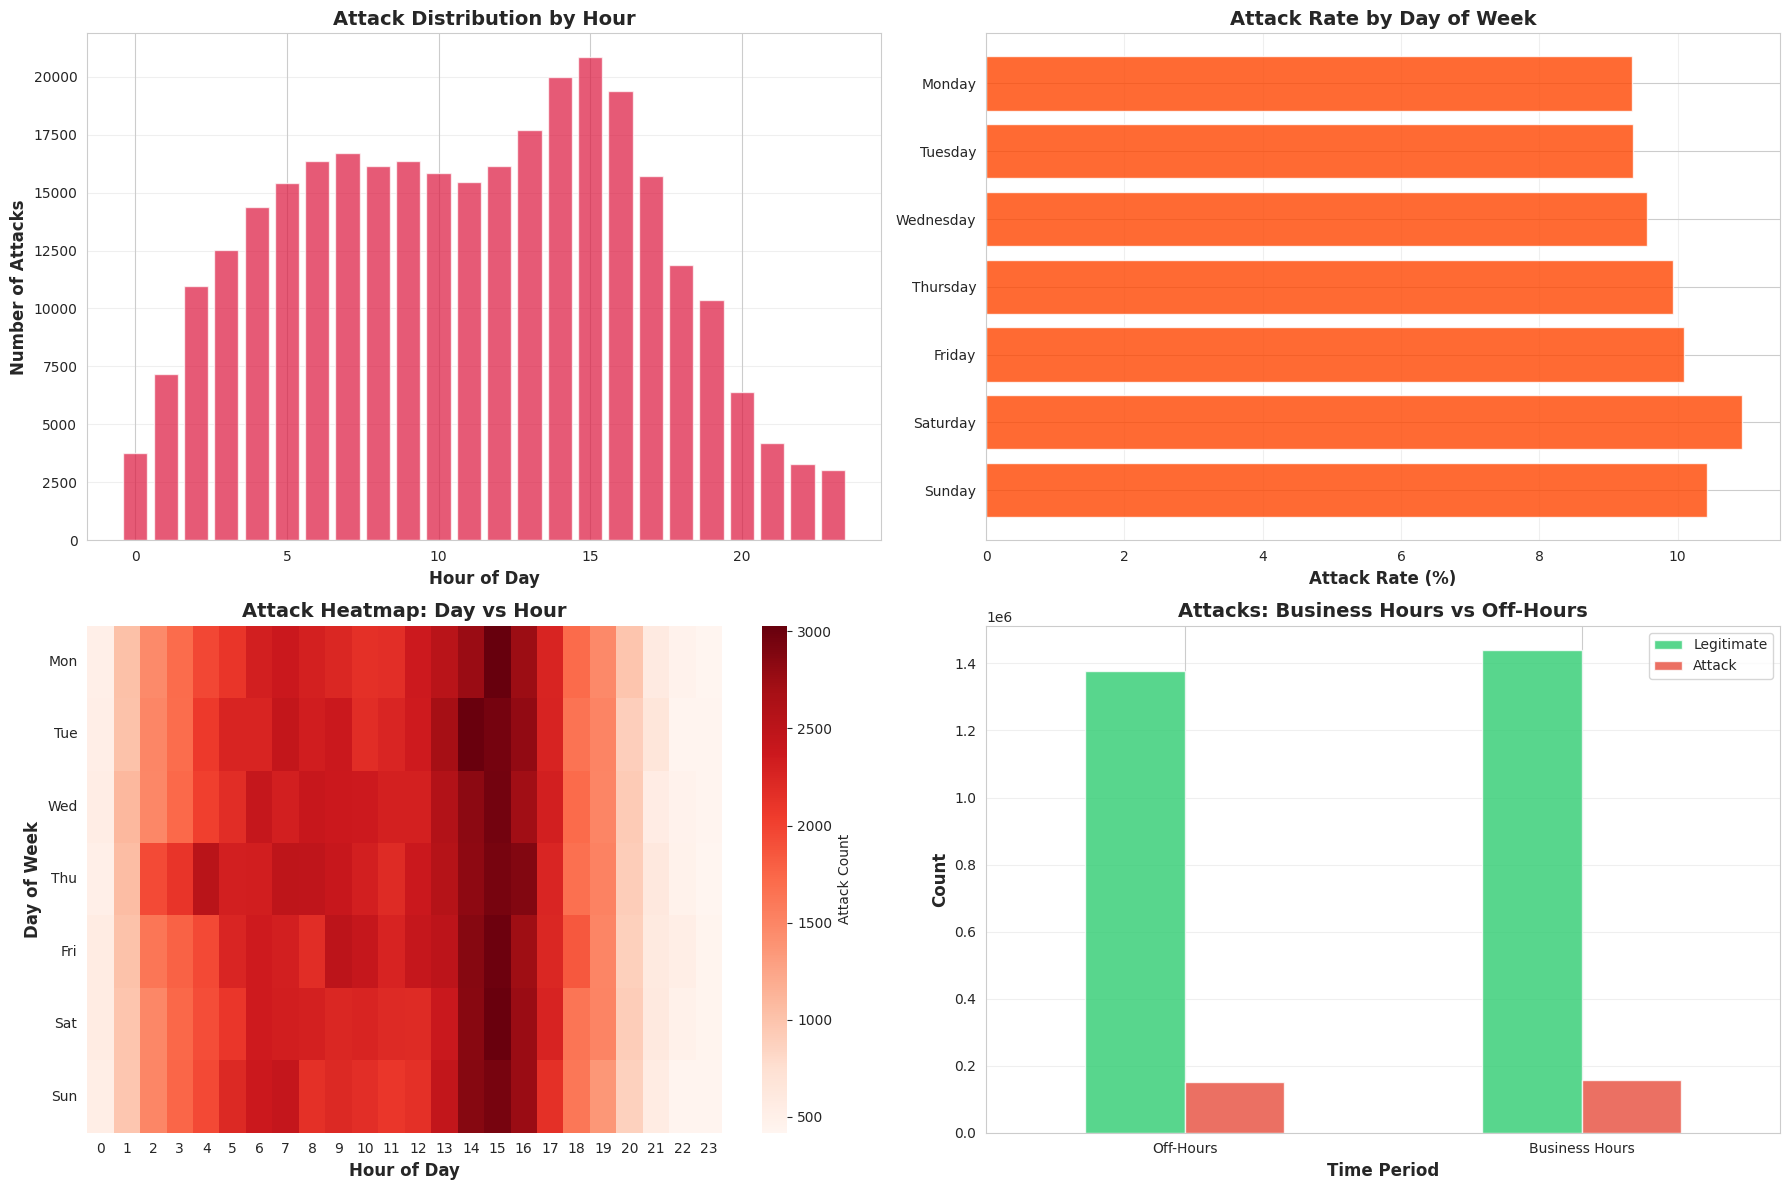

In [114]:
# %%
# ============================================================================
# STEP 16: TEMPORAL ATTACK PATTERN ANALYSIS
# ============================================================================
print("\n[STEP 16] Temporal Attack Pattern Analysis")
print("-" * 80)

# Create temporal features
df_clean['hour'] = df_clean['Login Timestamp'].dt.hour
df_clean['day_of_week'] = df_clean['Login Timestamp'].dt.dayofweek
df_clean['day_name'] = df_clean['Login Timestamp'].dt.day_name()
df_clean['is_weekend'] = df_clean['day_of_week'].isin([5, 6])
df_clean['is_business_hours'] = df_clean['hour'].between(9, 17)

# Attack rates by hour
attack_by_hour = df_clean.groupby('hour')['Is Attack IP'].agg(['sum', 'count', 'mean'])
attack_by_hour['attack_rate'] = attack_by_hour['mean'] * 100

print("\n🕒 Attack Rate by Hour of Day:")
print(attack_by_hour[['sum', 'attack_rate']])

# Visualization: Temporal patterns
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Plot 1: Attacks by Hour
axes[0, 0].bar(attack_by_hour.index, attack_by_hour['sum'], color='crimson', alpha=0.7)
axes[0, 0].set_xlabel('Hour of Day', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Number of Attacks', fontsize=12, fontweight='bold')
axes[0, 0].set_title('Attack Distribution by Hour', fontsize=14, fontweight='bold')
axes[0, 0].grid(axis='y', alpha=0.3)

# Plot 2: Attack Rate by Day of Week
attack_by_day = df_clean.groupby('day_name')['Is Attack IP'].mean() * 100
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
attack_by_day = attack_by_day.reindex(day_order)
axes[0, 1].barh(attack_by_day.index, attack_by_day.values, color='orangered', alpha=0.8)
axes[0, 1].set_xlabel('Attack Rate (%)', fontsize=12, fontweight='bold')
axes[0, 1].set_title('Attack Rate by Day of Week', fontsize=14, fontweight='bold')
axes[0, 1].invert_yaxis()
axes[0, 1].grid(axis='x', alpha=0.3)

# Plot 3: Heatmap - Hour vs Day of Week
pivot_attacks = df_clean.groupby(['day_of_week', 'hour'])['Is Attack IP'].sum().unstack(fill_value=0)
sns.heatmap(pivot_attacks, cmap='Reds', ax=axes[1, 0], cbar_kws={'label': 'Attack Count'})
axes[1, 0].set_xlabel('Hour of Day', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Day of Week', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Attack Heatmap: Day vs Hour', fontsize=14, fontweight='bold')
axes[1, 0].set_yticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], rotation=0)

# Plot 4: Business Hours vs Off-Hours Attacks
business_hours_attacks = df_clean.groupby(['is_business_hours', 'Is Attack IP']).size().unstack()
business_hours_attacks.plot(kind='bar', ax=axes[1, 1], color=['#2ecc71', '#e74c3c'], alpha=0.8)
axes[1, 1].set_xlabel('Time Period', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Count', fontsize=12, fontweight='bold')
axes[1, 1].set_title('Attacks: Business Hours vs Off-Hours', fontsize=14, fontweight='bold')
axes[1, 1].set_xticklabels(['Off-Hours', 'Business Hours'], rotation=0)
axes[1, 1].legend(['Legitimate', 'Attack'], loc='upper right')
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('16_temporal_attack_patterns.png', dpi=350, bbox_inches='tight')
print("\n✓ Saved: 16_temporal_attack_patterns.png")
plt.show()
plt.close()


[STEP 17] Geographic Attack Distribution
--------------------------------------------------------------------------------

🌍 Top 10 Countries by Attack Volume:
         attack_count  attack_rate  total_logins
Country                                         
US             242033       0.2782        869887
NO              15944       0.0121       1320873
PL               9263       0.1081         85685
ID               7074       0.2322         30460
RO               5989       0.4940         12124
DE               5928       0.0659         89948
AU               4207       0.1073         39223
IN               2488       0.0566         43943
GB               2304       0.0543         42455
UA               1973       0.0488         40432

⚠️  High-Risk Countries (attack rate > 5%): 96
         attack_count  attack_rate  total_logins
Country                                         
US             242033       0.2782        869887
PL               9263       0.1081         85685
ID     

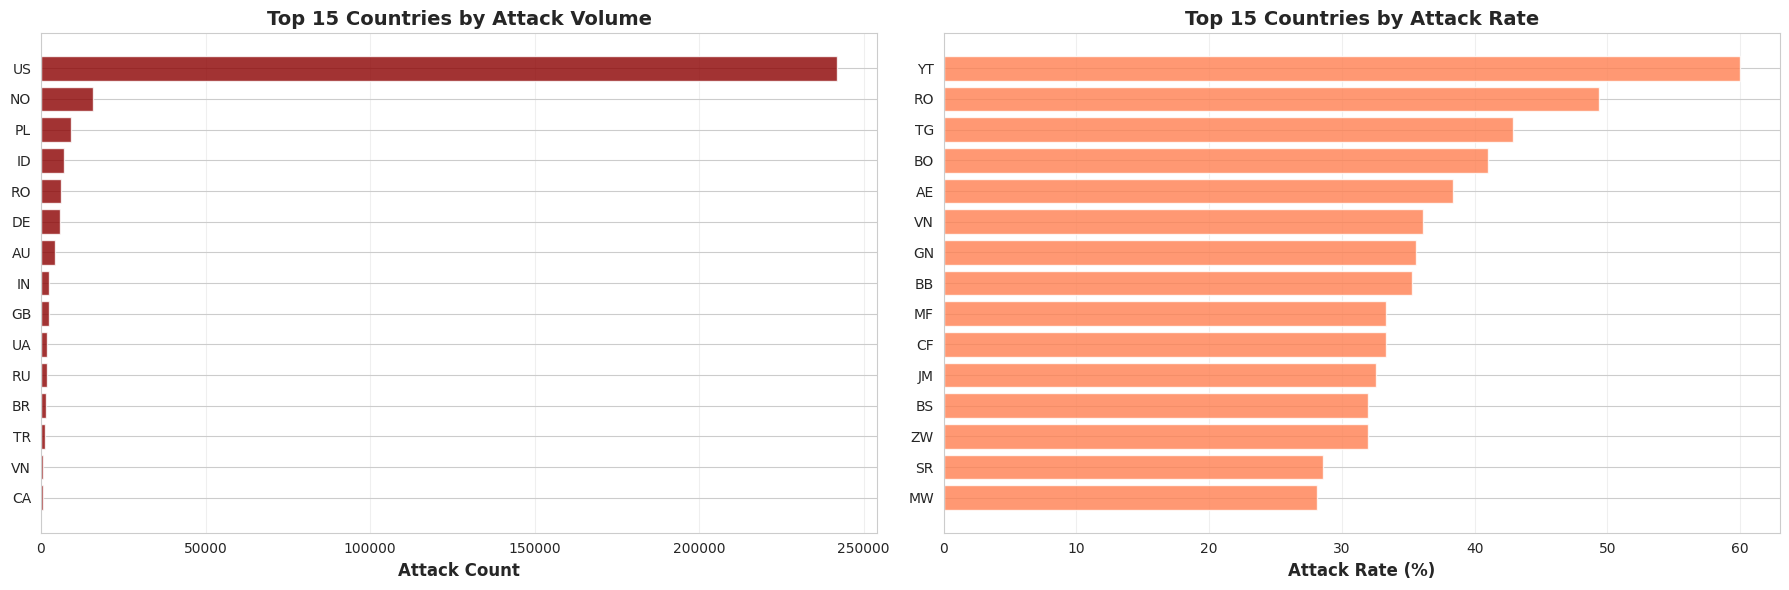

In [115]:
# %%
# ============================================================================
# STEP 17: GEOGRAPHIC ATTACK DISTRIBUTION
# ============================================================================
print("\n[STEP 17] Geographic Attack Distribution")
print("-" * 80)

# Attack rates by country
country_attacks = df_clean.groupby('Country').agg({
    'Is Attack IP': ['sum', 'mean', 'count']
}).round(4)
country_attacks.columns = ['attack_count', 'attack_rate', 'total_logins']
country_attacks = country_attacks.sort_values('attack_count', ascending=False)

print("\n🌍 Top 10 Countries by Attack Volume:")
print(country_attacks.head(10))

# High-risk countries (attack rate > 5%)
high_risk_countries = country_attacks[country_attacks['attack_rate'] > 0.05]
print(f"\n⚠️  High-Risk Countries (attack rate > 5%): {len(high_risk_countries)}")
print(high_risk_countries)

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot 1: Top countries by attack count
top_attack_countries = country_attacks.head(15)
axes[0].barh(range(len(top_attack_countries)), top_attack_countries['attack_count'], 
             color='darkred', alpha=0.8)
axes[0].set_yticks(range(len(top_attack_countries)))
axes[0].set_yticklabels(top_attack_countries.index)
axes[0].set_xlabel('Attack Count', fontsize=12, fontweight='bold')
axes[0].set_title('Top 15 Countries by Attack Volume', fontsize=14, fontweight='bold')
axes[0].invert_yaxis()
axes[0].grid(axis='x', alpha=0.3)

# Plot 2: Attack rate by country
top_rate_countries = country_attacks.nlargest(15, 'attack_rate')
axes[1].barh(range(len(top_rate_countries)), top_rate_countries['attack_rate'] * 100,
             color='coral', alpha=0.8)
axes[1].set_yticks(range(len(top_rate_countries)))
axes[1].set_yticklabels(top_rate_countries.index)
axes[1].set_xlabel('Attack Rate (%)', fontsize=12, fontweight='bold')
axes[1].set_title('Top 15 Countries by Attack Rate', fontsize=14, fontweight='bold')
axes[1].invert_yaxis()
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('17_geographic_attack_analysis.png', dpi=350, bbox_inches='tight')
print("\n✓ Saved: 17_geographic_attack_analysis.png")
plt.show()
plt.close()



[STEP 18] Geographic Attack Heatmap (Country vs Region)
--------------------------------------------------------------------------------

✓ Saved: 18_geographic_attack_heatmap.png


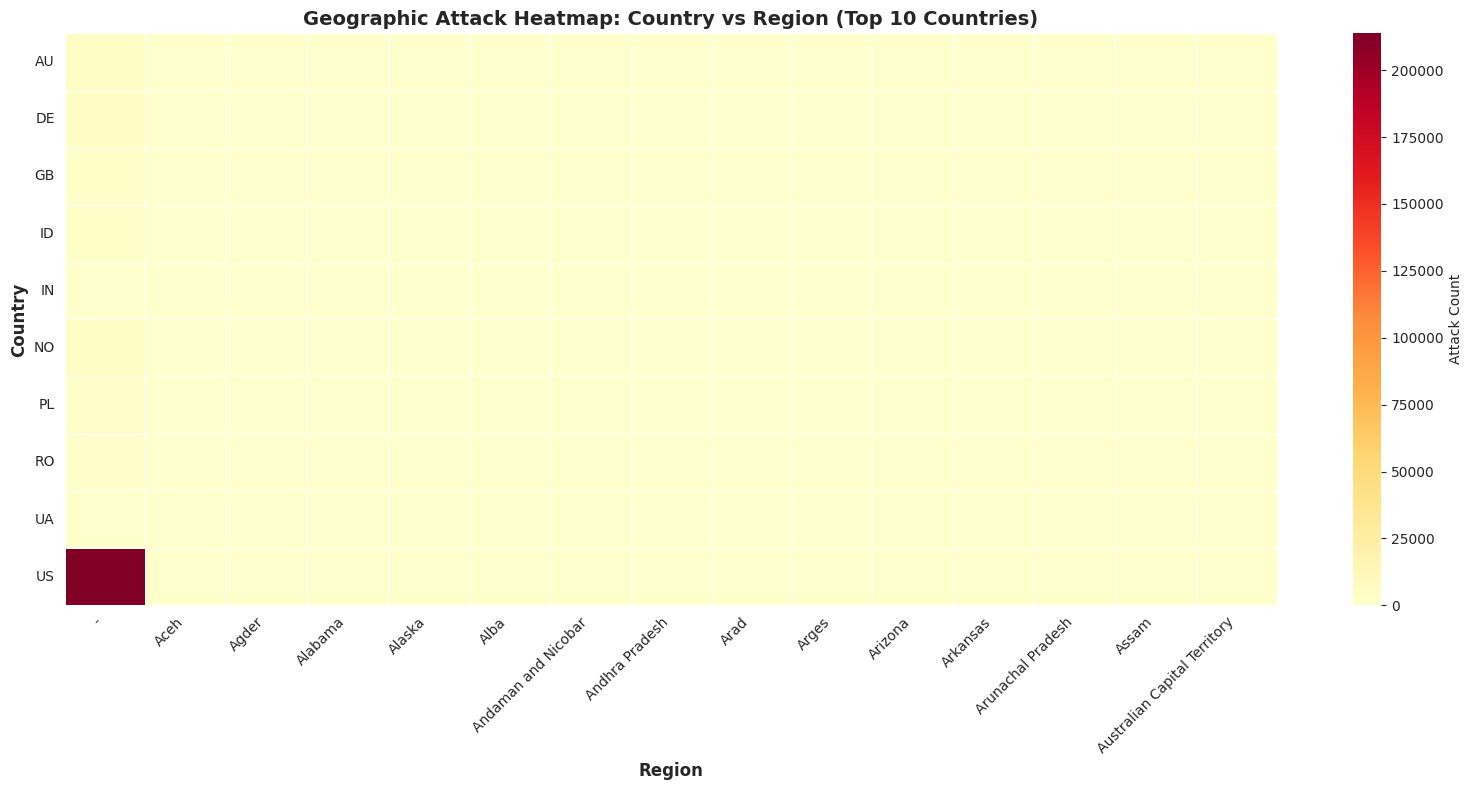


✓ Geographic heatmap analysis complete!


In [116]:
# %%
# ============================================================================
# STEP 18: GEOGRAPHIC ATTACK HEATMAP
# ============================================================================
print("\n[STEP 18] Geographic Attack Heatmap (Country vs Region)")
print("-" * 80)

# Create country-region attack heatmap for top countries
top_countries = country_attacks.head(10).index.tolist()
df_top_countries = df_clean[df_clean['Country'].isin(top_countries)]

# Get top regions for each country
pivot_geo = df_top_countries.groupby(['Country', 'Region'])['Is Attack IP'].agg(['sum', 'count'])
pivot_geo['attack_rate'] = (pivot_geo['sum'] / pivot_geo['count'] * 100).round(2)

# Create attack count heatmap
pivot_attack_count = df_top_countries.pivot_table(
    index='Country', 
    columns='Region', 
    values='Is Attack IP', 
    aggfunc='sum',
    fill_value=0
)

# Keep top regions
pivot_attack_count = pivot_attack_count.iloc[:, :15]

plt.figure(figsize=(16, 8))
sns.heatmap(pivot_attack_count, cmap='YlOrRd', annot=False, 
            cbar_kws={'label': 'Attack Count'}, linewidths=0.5)
plt.title('Geographic Attack Heatmap: Country vs Region (Top 10 Countries)', 
          fontsize=14, fontweight='bold')
plt.xlabel('Region', fontsize=12, fontweight='bold')
plt.ylabel('Country', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('18_geographic_attack_heatmap.png', dpi=350, bbox_inches='tight')
print("\n✓ Saved: 18_geographic_attack_heatmap.png")
plt.show()
plt.close()

print("\n✓ Geographic heatmap analysis complete!")



[STEP 19] Device & Browser Attack Analysis
--------------------------------------------------------------------------------

📱 Attack Patterns by Device Type:
             attack_count  attack_rate    total  attack_rate_pct
Device Type                                                     
mobile             276607     0.140720  1965653        14.072016
desktop             23061     0.029108   792270         2.910750
unknown              5554     0.063893    86926         6.389343
bot                  2564     0.012629   203031         1.262861
tablet               2295     0.028806    79672         2.880560

🌐 Top Browsers Used in Attacks:
                attack_count  attack_rate    total  attack_rate_pct
Browser_Family                                                     
Chrome                242222     0.123048  1968511        12.304833
Firefox                30390     0.107916   281609        10.791559
Android                 8513     0.026748   318269         2.674781
VLC         

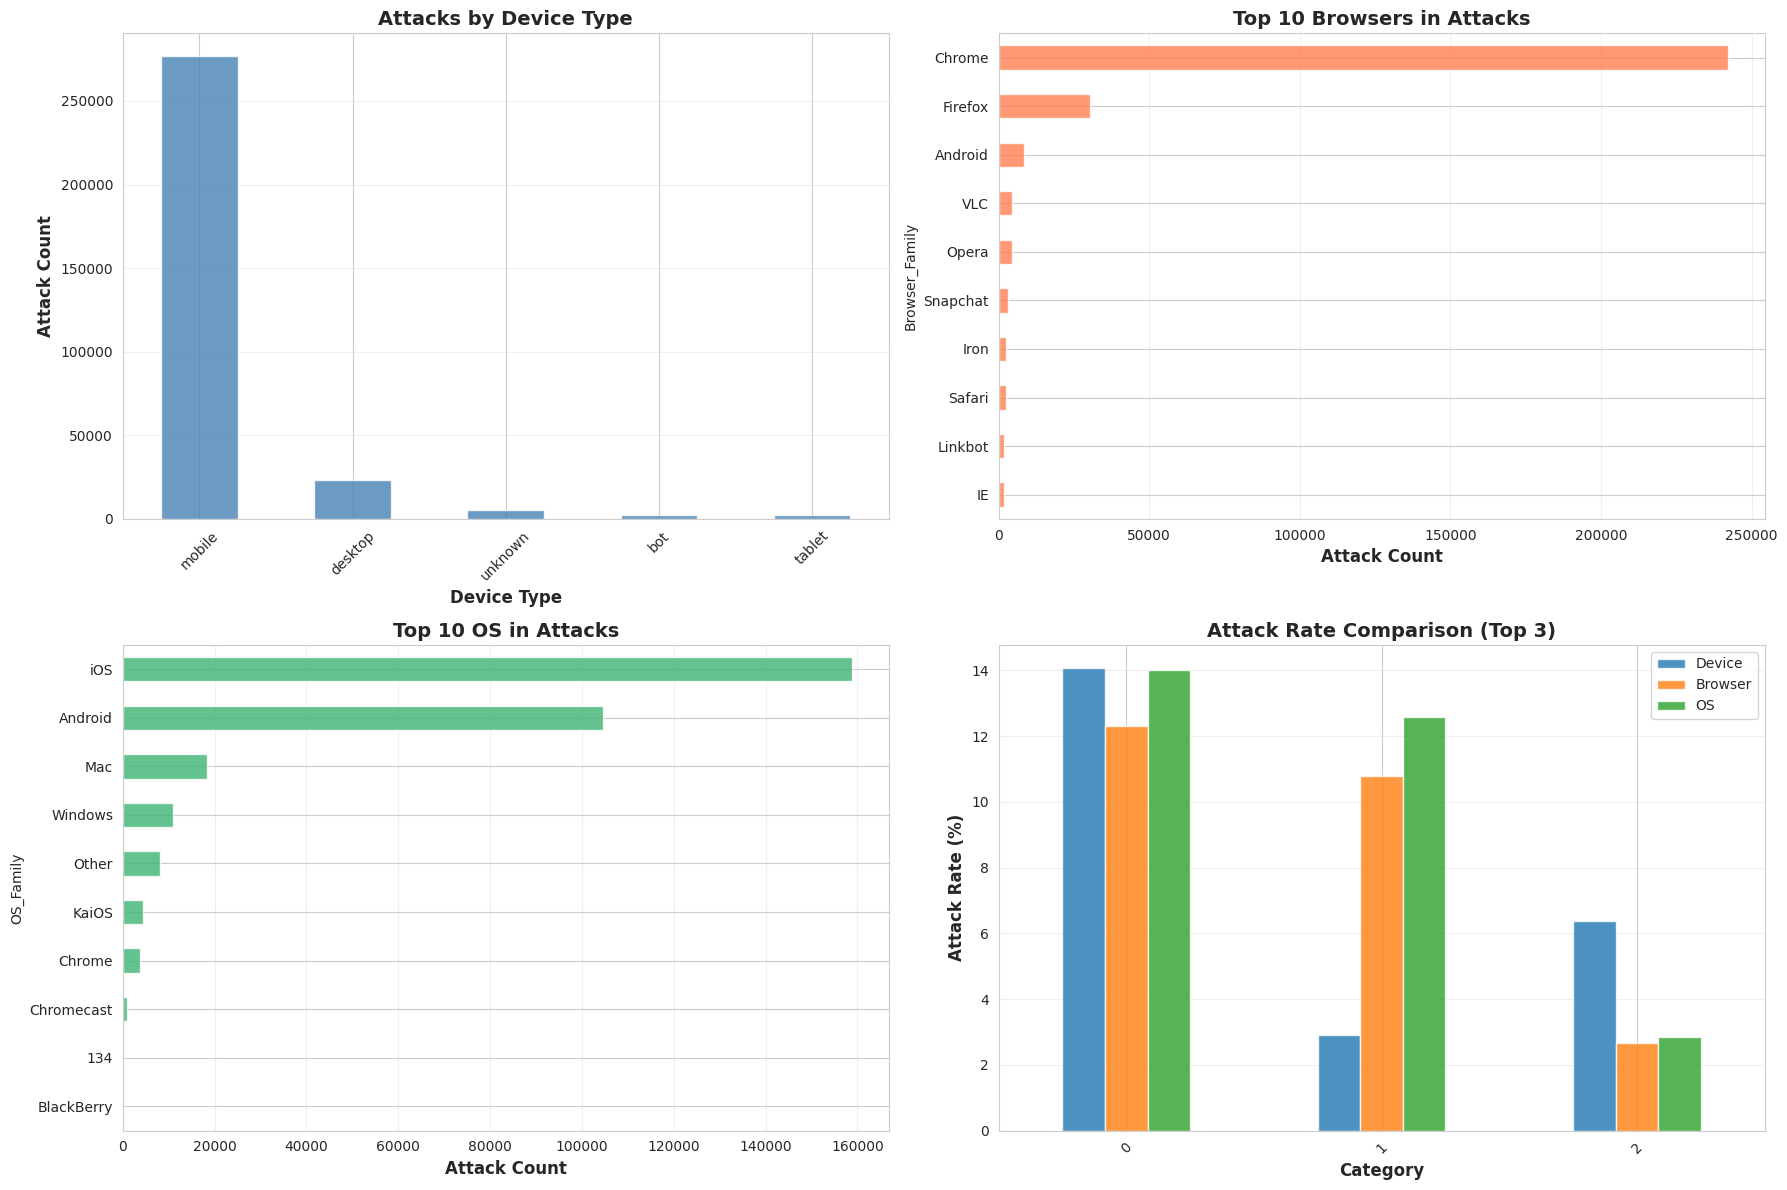


✓ Device & Browser analysis complete!


In [117]:
# %%
# ============================================================================
# STEP 19: DEVICE & BROWSER ATTACK PATTERNS
# ============================================================================
print("\n[STEP 19] Device & Browser Attack Analysis")
print("-" * 80)

# Device type analysis
device_attacks = df_clean.groupby('Device Type').agg({
    'Is Attack IP': ['sum', 'mean'],
    'User ID': 'count'
})
device_attacks.columns = ['attack_count', 'attack_rate', 'total']
device_attacks['attack_rate_pct'] = device_attacks['attack_rate'] * 100
device_attacks = device_attacks.sort_values('attack_count', ascending=False)

print("\n📱 Attack Patterns by Device Type:")
print(device_attacks)

# Browser analysis
df_clean['Browser_Family'] = df_clean['Browser Name and Version'].str.split().str[0]
browser_attacks = df_clean.groupby('Browser_Family').agg({
    'Is Attack IP': ['sum', 'mean'],
    'User ID': 'count'
}).sort_values(('Is Attack IP', 'sum'), ascending=False)
browser_attacks.columns = ['attack_count', 'attack_rate', 'total']
browser_attacks['attack_rate_pct'] = browser_attacks['attack_rate'] * 100

print("\n🌐 Top Browsers Used in Attacks:")
print(browser_attacks.head(10))

# OS analysis
df_clean['OS_Family'] = df_clean['OS Name and Version'].str.split().str[0]
os_attacks = df_clean.groupby('OS_Family').agg({
    'Is Attack IP': ['sum', 'mean'],
    'User ID': 'count'
}).sort_values(('Is Attack IP', 'sum'), ascending=False)
os_attacks.columns = ['attack_count', 'attack_rate', 'total']
os_attacks['attack_rate_pct'] = os_attacks['attack_rate'] * 100

print("\n💻 Operating Systems in Attacks:")
print(os_attacks.head(10))

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Plot 1: Device type distribution
device_attacks['attack_count'].plot(kind='bar', ax=axes[0, 0], color='steelblue', alpha=0.8)
axes[0, 0].set_xlabel('Device Type', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Attack Count', fontsize=12, fontweight='bold')
axes[0, 0].set_title('Attacks by Device Type', fontsize=14, fontweight='bold')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(axis='y', alpha=0.3)

# Plot 2: Browser family attacks
browser_attacks['attack_count'].head(10).plot(kind='barh', ax=axes[0, 1], 
                                               color='coral', alpha=0.8)
axes[0, 1].set_xlabel('Attack Count', fontsize=12, fontweight='bold')
axes[0, 1].set_title('Top 10 Browsers in Attacks', fontsize=14, fontweight='bold')
axes[0, 1].invert_yaxis()
axes[0, 1].grid(axis='x', alpha=0.3)

# Plot 3: OS family attacks
os_attacks['attack_count'].head(10).plot(kind='barh', ax=axes[1, 0],
                                          color='mediumseagreen', alpha=0.8)
axes[1, 0].set_xlabel('Attack Count', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Top 10 OS in Attacks', fontsize=14, fontweight='bold')
axes[1, 0].invert_yaxis()
axes[1, 0].grid(axis='x', alpha=0.3)

# Plot 4: Attack rate comparison
comparison_data = pd.DataFrame({
    'Device': device_attacks['attack_rate_pct'].values[:3],
    'Browser': browser_attacks['attack_rate_pct'].head(3).values,
    'OS': os_attacks['attack_rate_pct'].head(3).values
})
comparison_data.plot(kind='bar', ax=axes[1, 1], alpha=0.8)
axes[1, 1].set_xlabel('Category', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Attack Rate (%)', fontsize=12, fontweight='bold')
axes[1, 1].set_title('Attack Rate Comparison (Top 3)', fontsize=14, fontweight='bold')
axes[1, 1].legend(loc='upper right')
axes[1, 1].grid(axis='y', alpha=0.3)
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('19_device_browser_attack_patterns.png', dpi=350, bbox_inches='tight')
print("\n✓ Saved: 19_device_browser_attack_patterns.png")
plt.show()
plt.close()

print("\n✓ Device & Browser analysis complete!")

In [118]:
# %%
# ============================================================================
# STEP 20: FINAL DATA QUALITY REPORT
# ============================================================================
print("\n[STEP 20] Final Data Quality Report")
print("=" * 80)

print(f"\n✓ Dataset is ready for model training!")
print(f"\nFinal Dataset Statistics:")
print(f"  Shape: {df_clean.shape}")
print(f"  Memory: {df_clean.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"  Missing values: {df_clean.isnull().sum().sum()}")
print(f"  Duplicates: {df_clean.duplicated().sum()}")


[STEP 20] Final Data Quality Report

✓ Dataset is ready for model training!

Final Dataset Statistics:
  Shape: (3127552, 22)
  Memory: 2664.55 MB
  Missing values: 0
  Duplicates: 0


In [146]:
!zip -r my_kaggle_project.zip /kaggle/working/


  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/17_geographic_attack_analysis.png (deflated 35%)
  adding: kaggle/working/distribution_analysis.png (deflated 29%)
  adding: kaggle/working/device_browser_attack_patterns.png (deflated 28%)
  adding: kaggle/working/temporal_attack_patterns.png (deflated 28%)
  adding: kaggle/working/geographic_attack_analysis.png (deflated 33%)
  adding: kaggle/working/19_device_browser_attack_patterns.png (deflated 31%)
  adding: kaggle/working/LogisticRegression.joblib (deflated 37%)
  adding: kaggle/working/Stacking_Ensemble.joblib (deflated 31%)
  adding: kaggle/working/missing_values_analysis.png (deflated 34%)
  adding: kaggle/working/rba_dataset_cleaned.csv (deflated 85%)
  adding: kaggle/working/outlier_detection.png (deflated 47%)
  adding: kaggle/working/.virtual_documents/ (stored 0%)
  adding: kaggle/working/.virtual_documents/__notebook_source__.ipynb (deflated 76%)
  adding: kaggle/working/07_outlier_detection.png (deflated 45